In [1]:
import os, sys, glob

In [2]:
import sys, os, glob
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('/users/rhydian/self-supervised-project')

from keypoint_alignment_dataset import KeypointAlignmentDataset
from models.SSECEncoders import VGGEncoder, HighResVGGEncoder
from train_SSEC import load_models
import train_angle_regressor
from registration import *
from plotting import show_matches, show_warped_perspective, show_transformed_keypoints
import torch.nn.functional as F

class config():
    TRAINING_AUGMENTATION=False
    DATASET_ROOT = '/scratch/shared/beegfs/rhydian/UKBiobank'
    #MODEL_LOAD_PATH = '/users/rhydian/self-supervised-project/model_weights/SSECEncodersHighRes2'
    MODEL_LOAD_PATH = '/users/rhydian/self-supervised-project/model_weights/SSECEncodersBothBoth'
    USE_EQUAL_RES = True
    # ENCODER_TYPE = HighResVGGEncoder
    ENCODER_TYPE = VGGEncoder
    EMBEDDING_SIZE = 128
    USE_CUDA = False 
    UPSAMPLE_FACTOR = 2 # amount feature maps scaled up for subpixel accuracy
    USE_CYCLIC = True # use cyclic point correlation
    USE_RANSAC = True
    RANSAC_TOLERANCE = 15
    GRID_RES = 1
    ALLOW_SCALING = False
    NUM_DISCRIM_POINTS = int(200*GRID_RES**2) # number of correlating pairs to find
    METHOD = 'MATCH_KEYPOINT' # from DENSE, SIFT, MATCH_KEYPOINT
    ROTATION_RANGE = (-2,2)
    ROTATION_SAMPLES=40
    REFINEMENT_NETWORK_PATH='../model_weights/angle_regressor4'
    assert METHOD in ['MATCH_KEYPOINT','DENSE','SIFT']


def set_up():
    global c
    ds  = KeypointAlignmentDataset()
    dxa_model, mri_model, val_stats, epochs = load_models(c.ENCODER_TYPE, c.EMBEDDING_SIZE, 
                                                          c.MODEL_LOAD_PATH, c.USE_CUDA, SINGLE_MRI=0, SINGLE_DXA=0 )
    refinement_model, _, _ = train_angle_regressor.load_model(c.REFINEMENT_NETWORK_PATH, c.USE_CUDA)
    if c.USE_CUDA:
        refinement_model.cuda()
    return ds, dxa_model, mri_model, refinement_model, val_stats, epochs

c = config()
ds, dxa_model, mri_model, refinement_mode,  val_stats, epochs = set_up()

/users/rhydian/anaconda3/envs/torch_env/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729006826/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Trying to load from /users/rhydian/self-supervised-project/model_weights/SSECEncodersBothBoth
==> Resuming model trained for 106 epochs...
Trying to load from ../model_weights/angle_regressor4
==> Resuming model trained for 7 epochs...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


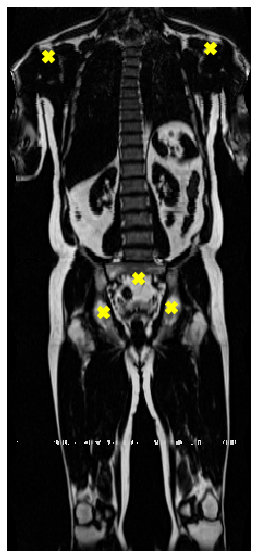

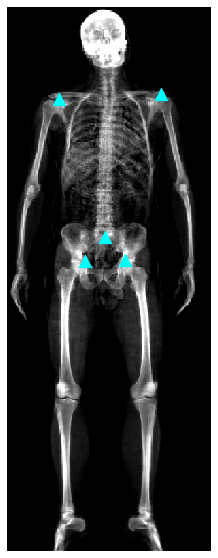

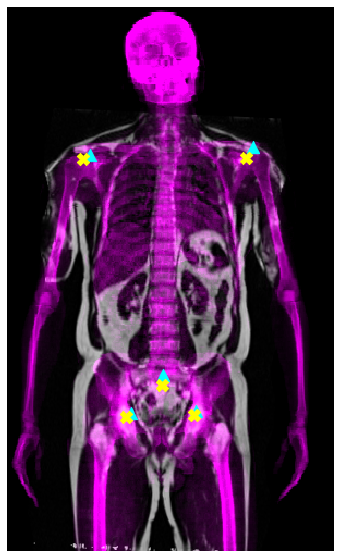

In [4]:
from gen_utils import *
idx = 5
sample = ds[idx]
colors=['orange','blue','lime','yellow','cyan']
sample['dxa_keypoints'] = ((np.array(sample['dxa_keypoints'])*1/0.911 + np.array([10,0]))).tolist()


# mri img
plt.figure(figsize=(10,10))
plt.imshow(sample['mri_img'][0],cmap='gray')
plt.axis('off')
for idx, point in enumerate(sample['mri_keypoints']):
    plt.scatter(point[1],point[0],marker='X',s=150,c='yellow')
plt.savefig('mri_and_keypoints')
plt.figure(figsize=(10,10))
plt.imshow(sample['dxa_img'][0],cmap='gray')
plt.axis('off')
for idx, point in enumerate(sample['dxa_keypoints']):
    plt.scatter(point[1],point[0],marker='^',s=150,c='cyan')
plt.savefig('dxa_and_keypoints')
    
plt.figure(figsize=(10,10))

lowes_good_matches,lowes_M = LowesTest(sample['dxa_img'][None], sample['mri_img'][None], dxa_model, mri_model, 0.93,True,c.RANSAC_TOLERANCE,False)
lowes_estimate_points = transform_points(sample['mri_keypoints'],lowes_M)
new_lowes_M = lowes_M.copy()
new_lowes_M[1,2],new_lowes_M[0,2]=new_lowes_M[0,2],new_lowes_M[1,2]
new_lowes_M[1,0],new_lowes_M[0,1]=new_lowes_M[0,1],new_lowes_M[1,0]
warped_mri = cv2.warpPerspective((255*sample['mri_img'][0].numpy()).astype('uint8'),
                                 new_lowes_M,(sample['dxa_img'].shape[-1],
                                          sample['dxa_img'].shape[-2]))

plt.imshow((grayscale(warped_mri/255)+red(sample['dxa_img'][0])+\
           blue(sample['dxa_img'][0]))[:500])

for idx, point in enumerate(sample['dxa_keypoints']):
    plt.scatter(point[1],point[0],marker='^',s=150,c='cyan')
    
for idx, point in enumerate(lowes_estimate_points):
    plt.scatter(point[1],point[0],marker='X',s=150,c='yellow')
plt.axis('off')
plt.savefig('lowes.png')




In [ ]:
M=np.eye(3)
estimate_points = transform_points(sample['mri_keypoints'],M)
new_M = M.copy()
new_M[1,2],new_M[0,2]=new_M[0,2],new_M[1,2]
new_M[1,0],new_M[0,1]=new_M[0,1],new_M[1,0]
warped_mri = cv2.warpPerspective((255*sample['mri_img'][0].numpy()).astype('uint8'),
                                 new_M,(sample['dxa_img'].shape[-1],
                                          sample['dxa_img'].shape[-2]))

plt.figure(figsize=(10,10))
plt.imshow((grayscale(warped_mri/255)+red(sample['dxa_img'][0])+\
           blue(sample['dxa_img'][0]))[:500])

for idx, point in enumerate(sample['dxa_keypoints']):
    plt.scatter(point[1],point[0],marker='^',s=150,c='cyan')
    
for idx, point in enumerate(estimate_points):
    plt.scatter(point[1],point[0],marker='X',s=150,c='yellow')
plt.axis('off')
plt.savefig('none.png')

In [ ]:
 M,best_idx,angles = get_dense_correspondance(sample['dxa_img'],sample['mri_img'],dxa_model,mri_model,
                                                         c.USE_CUDA, c.UPSAMPLE_FACTOR,c.ROTATION_RANGE, c.ROTATION_SAMPLES) 

estimate_points = transform_points(sample['mri_keypoints'],M)
new_M = M.copy()
new_M[1,2],new_M[0,2]=new_M[0,2],new_M[1,2]
new_M[1,0],new_M[0,1]=new_M[0,1],new_M[1,0]
warped_mri = cv2.warpPerspective((255*sample['mri_img'][0].numpy()).astype('uint8'),
                                 new_M,(sample['dxa_img'].shape[-1],
                                          sample['dxa_img'].shape[-2]))

plt.figure(figsize=(10,10))
plt.imshow((grayscale(warped_mri/255)+red(sample['dxa_img'][0])+\
           blue(sample['dxa_img'][0]))[:500])

for idx, point in enumerate(sample['dxa_keypoints']):
    plt.scatter(point[1],point[0],marker='^',s=150,c='cyan')
    
for idx, point in enumerate(estimate_points):
    plt.scatter(point[1],point[0],marker='X',s=150,c='yellow')
plt.axis('off')
plt.savefig('dense.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


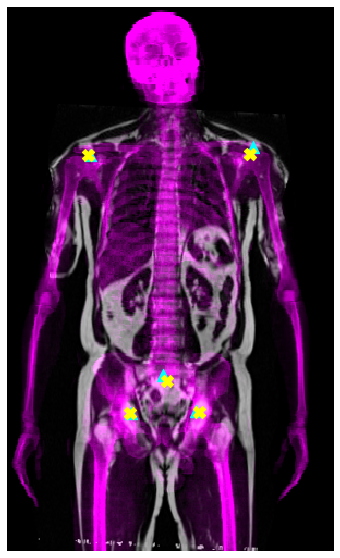

In [15]:
M,R,angle,t_x, t_y = RefinementNetwork(sample['dxa_img'][None], sample['mri_img'][None], dxa_model, mri_model,
                                  0.93,c.RANSAC_TOLERANCE,c.USE_CUDA, refinement_mode,sample['mri_keypoints'])
new_M = M.copy()
new_M[1,2],new_M[0,2]=new_M[0,2],new_M[1,2]
new_M[1,0],new_M[0,1]=new_M[0,1],new_M[1,0]
warped_mri = cv2.warpPerspective((255*sample['mri_img'][0].numpy()).astype('uint8'),
                                 new_M,(sample['dxa_img'].shape[-1],
                                          sample['dxa_img'].shape[-2]))
new_src_pts = np.zeros_like(sample['mri_keypoints'])
for idx in range(len(sample['mri_keypoints'])):
    new_src_pts[idx] =(R@np.array(sample['mri_keypoints'][idx]+[1])).tolist()
    
warped_mri2 = TF.affine(torch.Tensor(warped_mri)[None],angle,(t_x,t_y),1,(0,0))[0]
estimate_points = transform_points(new_src_pts,M)
plt.figure(figsize=(10,10))

plt.imshow((grayscale(warped_mri2/255)+red(sample['dxa_img'][0])+\
           blue(sample['dxa_img'][0]))[:500])

for idx, point in enumerate(sample['dxa_keypoints']):
    plt.scatter(point[1],point[0],marker='^',s=150,c='cyan')
    
for idx, point in enumerate(estimate_points):
    plt.scatter(point[1],point[0],marker='X',s=150,c='yellow')
    
plt.axis('off')
plt.savefig('refinement.png')